#LinearRegession_INTERNET


# 1. VERİYİ YÜKLEME

In [ ]:
!pip install --upgrade google-cloud-bigquery pandas-gbq db-dtypes -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from google.colab import auth
from google.cloud import bigquery


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
auth.authenticate_user()

print('✅ Kimlik doğrulama başarılı!')

✅ Kimlik doğrulama başarılı!


In [ ]:
project_id = 'ndn-project-485520'

client = bigquery.Client(project=project_id)

print(f"✅ Bağlantı kuruldu: {project_id}")

✅ Bağlantı kuruldu: ndn-project-485520


In [ ]:
query = """
SELECT
*
FROM `ndn-project-485520.telecom_italy_data.linear_regression_internet`
"""

In [ ]:
df = client.query(query).to_dataframe()

# 2. VERİ KEŞFİ VE İSTATİSTİKLER

In [ ]:
df.head()

,cell_id,date,hour,day_of_week,day_type,country_code,sms_in,sms_out,call_in,call_out,internet,total_activity,is_outlier
0,9693,2013-11-01,15,6,Weekday,420,0.0000,0.0000,0.0000,0.0000,0.0767,0.0767,0
1,3673,2013-11-01,10,6,Weekday,0,15.8428,0.0000,0.0000,0.0000,0.0000,15.8428,1
2,9605,2013-11-01,13,6,Weekday,33,0.0000,0.0000,0.0000,0.0000,0.0234,0.0234,0
3,4841,2013-11-01,16,6,Weekday,41,0.0000,0.0000,0.0000,0.0000,0.7201,0.7201,0
4,7257,2013-11-01,15,6,Weekday,39,27.8461,24.1144,38.6214,40.9136,1134.4396,1265.9351,1


# Outlier analizi

In [ ]:
print(f"\n📊 Outlier bilgisi:")
print(f"✓ is_outlier=1 olan kayıt: {df['is_outlier'].sum():,} ({df['is_outlier'].sum()/len(df)*100:.2f}%)")


📊 Outlier bilgisi:
✓ is_outlier=1 olan kayıt: 2,512,122 (16.65%)


# 3. OUTLIER TEMİZLEME


In [ ]:
print("\n[ADIM 3/12] Outlier'lar temizleniyor...")

n_before = len(df)
df_clean = df[df['is_outlier'] == 0].copy()
n_after = len(df_clean)
n_removed = n_before - n_after

print(f"✓ Outlier öncesi: {n_before:,} satır")
print(f"✓ Outlier sonrası: {n_after:,} satır")
print(f"✓ Temizlenen: {n_removed:,} satır ({100*n_removed/n_before:.2f}%)")


[ADIM 3/12] Outlier'lar temizleniyor...
✓ Outlier öncesi: 15,089,165 satır
✓ Outlier sonrası: 12,577,043 satır
✓ Temizlenen: 2,512,122 satır (16.65%)


# 4. FEATURE VE TARGET SEÇ

In [ ]:
print("\n[3/5] Feature ve target seçiliyor...")

# Basit feature seçimi (en önemli 6 feature)
features = ['hour', 'day_of_week', 'sms_in', 'call_in', 'cell_id', 'sms_out']

X = df[features]
y = df['internet']

print(f"✓ Features: {len(features)} adet")
print(f"✓ Hedef: internet")


[3/5] Feature ve target seçiliyor...
✓ Features: 6 adet
✓ Hedef: internet


# 5. MODELİ EĞİT

In [ ]:
print("\n[4/5] Model eğitiliyor...")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✓ Train: {len(X_train):,} satır")
print(f"✓ Test: {len(X_test):,} satır")

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Tahmin
predictions = model.predict(X_test)

print("✓ Model eğitildi!")


[4/5] Model eğitiliyor...
✓ Train: 12,071,332 satır
✓ Test: 3,017,833 satır
✓ Model eğitildi!


# 6. SONUÇLAR

In [ ]:
print("\n[5/5] Sonuçlar hesaplanıyor...")

# Metrikler
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("\n" + "="*70)
print("SONUÇLAR")
print("="*70)
print(f"R² Score:  {r2:.4f}  (1.0 = mükemmel)")
print(f"MAE:       {mae:.2f}   (ortalama hata)")
print(f"MSE:       {mse:.2f}   (hata kareler toplamı)")
print(f"RMSE:      {rmse:.2f}  (hata büyüklüğü)")


[5/5] Sonuçlar hesaplanıyor...

SONUÇLAR
R² Score:  0.8223  (1.0 = mükemmel)
MAE:       28.54   (ortalama hata)
MSE:       14495.47   (hata kareler toplamı)
RMSE:      120.40  (hata büyüklüğü)


In [ ]:
# Performans yorumu
print("\nPerformans Yorumu:")
if r2 >= 0.80:
    print("  🎉 Mükemmel! Model çok iyi tahmin ediyor.")
elif r2 >= 0.70:
    print("  ✅ Çok iyi! Güvenilir tahminler yapılabilir.")
elif r2 >= 0.60:
    print("  👍 İyi! Makul tahminler yapılabilir.")
else:
    print("  ⚠️  Orta. İyileştirme yapılabilir.")


Performans Yorumu:
  🎉 Mükemmel! Model çok iyi tahmin ediyor.


In [ ]:
# Katsayılar
print("\nEn Önemli 3 Feature:")
coef_df = pd.DataFrame({
    'Feature': features,
    'Katsayı': model.coef_
}).sort_values('Katsayı', key=abs, ascending=False)

for i, row in coef_df.head(3).iterrows():
    print(f"  {row['Feature']:15s}: {row['Katsayı']:8.4f}")


En Önemli 3 Feature:
  sms_out        :  10.1333
  call_in        :   7.0943
  sms_in         :   2.1213


# 7. GRAFİKLER


[BONUS] Grafik oluşturuluyor...
✓ Grafik kaydedildi: internet_model_results.png


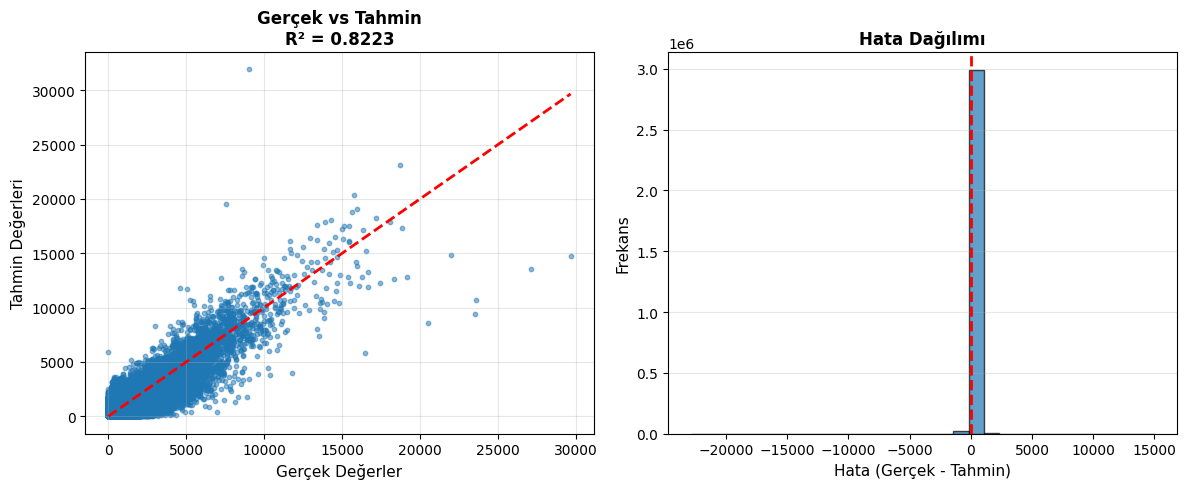

In [ ]:
print("\n[BONUS] Grafik oluşturuluyor...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Grafik 1: Gerçek vs Tahmin
axes[0].scatter(y_test, predictions, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2)
axes[0].set_xlabel('Gerçek Değerler', fontsize=11)
axes[0].set_ylabel('Tahmin Değerleri', fontsize=11)
axes[0].set_title(f'Gerçek vs Tahmin\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Grafik 2: Hata Dağılımı
residuals = y_test - predictions
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Hata (Gerçek - Tahmin)', fontsize=11)
axes[1].set_ylabel('Frekans', fontsize=11)
axes[1].set_title('Hata Dağılımı', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('internet_model_results.png', dpi=150, bbox_inches='tight')
print("✓ Grafik kaydedildi: internet_model_results.png")


# ÖZET

In [ ]:
print("\n" + "="*70)
print("✅ TAMAMLANDI!")
print("="*70)
print(f"""
📊 Model: Linear Regression
🎯 Hedef: internet kullanımı
📈 R² Score: {r2:.4f}
📏 RMSE: {rmse:.2f}

📂 Oluşturulan dosyalar:
   - internet_model_results.png
   - internet_model_simple.pkl

💡 Modeli kullanmak için:
   model = joblib.load('internet_model_simple.pkl')
   tahmin = model.predict([[hour, day_of_week, sms_in, call_in, cell_id, sms_out]])
""")
print("="*70)


✅ TAMAMLANDI!

📊 Model: Linear Regression
🎯 Hedef: internet kullanımı
📈 R² Score: 0.8223
📏 RMSE: 120.40

📂 Oluşturulan dosyalar:
   - internet_model_results.png
   - internet_model_simple.pkl

💡 Modeli kullanmak için:
   model = joblib.load('internet_model_simple.pkl')
   tahmin = model.predict([[hour, day_of_week, sms_in, call_in, cell_id, sms_out]])



# 8. MODELİ KAYDET

In [ ]:
print("\n[KAYDETME] Model kaydediliyor...")

import joblib
joblib.dump(model, 'internet_model_simple.pkl')
print("✓ Model kaydedildi: internet_model_simple.pkl")


[KAYDETME] Model kaydediliyor...
✓ Model kaydedildi: internet_model_simple.pkl


# 9. POWER BI DOSYALARI OLUŞTUR

In [ ]:
# =============================================================================
# 2. CREATE POWER BI FILES
# =============================================================================
print("\n[2/3] Creating Excel files...")

import os

# Create folder
output_dir = 'PowerBI_Internet'
os.makedirs(output_dir, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────────────
# FILE 1: Prediction Results
# ─────────────────────────────────────────────────────────────────────────────
predictions_df = pd.DataFrame({
    'ID': range(len(y_test)),
    'Actual_Internet': y_test.values,
    'Predicted_Internet': predictions,
    'Error': y_test.values - predictions,
    'Absolute_Error': np.abs(y_test.values - predictions),
    'Error_Percentage': np.abs((y_test.values - predictions) / (y_test.values + 0.001)) * 100,
    'Squared_Error': (y_test.values - predictions) ** 2
})

# Add test features
X_test_reset = X_test.reset_index(drop=True)
predictions_df = pd.concat([predictions_df, X_test_reset], axis=1)

# Add categories
predictions_df['Hour_Category'] = predictions_df['hour'].apply(
    lambda x: 'Night' if x < 6 else ('Morning' if x < 12 else ('Afternoon' if x < 18 else 'Evening'))
)
predictions_df['Day_Type'] = predictions_df['day_of_week'].apply(
    lambda x: 'Weekday' if x <= 5 else 'Weekend'
)
predictions_df['Prediction_Quality'] = predictions_df['Error_Percentage'].apply(
    lambda x: 'Excellent' if x < 5 else ('Good' if x < 10 else ('Fair' if x < 20 else 'Poor'))
)

# Save (Excel and CSV)
# predictions_df.to_excel(f'{output_dir}/1_Prediction_Results.xlsx', index=False) # Removed due to Excel row limit
predictions_df.to_csv(f'{output_dir}/1_Prediction_Results.csv', index=False)
print(f"✓ 1/6: Prediction results ({len(predictions_df):,} rows)")

# ─────────────────────────────────────────────────────────────────────────────
# FILE 2: Model Metrics (for KPI Cards)
# ─────────────────────────────────────────────────────────────────────────────
metrics_df = pd.DataFrame({
    'Metric': ['R2_Score', 'RMSE', 'MAE', 'Test_Data', 'Feature_Count',
               'Avg_Actual', 'Avg_Predicted', 'Max_Error', 'Min_Error'],
    'Value': [
        r2, rmse, mae,
        len(y_test), len(features),
        y_test.mean(), predictions.mean(),
        (y_test.values - predictions).max(),
        (y_test.values - predictions).min()
    ]
})

metrics_df.to_excel(f'{output_dir}/2_Model_Metrics.xlsx', index=False)
metrics_df.to_csv(f'{output_dir}/2_Model_Metrics.csv', index=False)
print(f"✓ 2/6: Model metrics (9 metrics)")

# ─────────────────────────────────────────────────────────────────────────────
# FILE 3: Feature Coefficients
# ─────────────────────────────────────────────────────────────────────────────
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_,
    'Absolute_Coefficient': np.abs(model.coef_),
    'Direction': ['Positive' if c > 0 else 'Negative' for c in model.coef_]
}).sort_values('Absolute_Coefficient', ascending=False)

coef_df['Importance_Rank'] = range(1, len(coef_df) + 1)

coef_df.to_excel(f'{output_dir}/3_Feature_Coefficients.xlsx', index=False)
coef_df.to_csv(f'{output_dir}/3_Feature_Coefficients.csv', index=False)
print(f"✓ 3/6: Feature coefficients ({len(features)} features)")

# ─────────────────────────────────────────────────────────────────────────────
# FILE 4: Hourly Analysis
# ─────────────────────────────────────────────────────────────────────────────
hourly = df.groupby('hour')['internet'].agg(['mean', 'std', 'count', 'min', 'max']).reset_index()
hourly.columns = ['Hour', 'Average', 'Std', 'Count', 'Min', 'Max']

# Add prediction errors
hourly_errors = predictions_df.groupby('hour')['Absolute_Error'].mean().reset_index()
hourly_errors.columns = ['Hour', 'Average_Error']
hourly = pd.merge(hourly, hourly_errors, on='Hour', how='left')

hourly.to_excel(f'{output_dir}/4_Hourly_Analysis.xlsx', index=False)
hourly.to_csv(f'{output_dir}/4_Hourly_Analysis.csv', index=False)
print(f"✓ 4/6: Hourly analysis (24 hours)")

# ─────────────────────────────────────────────────────────────────────────────
# FILE 5: Error Distribution
# ─────────────────────────────────────────────────────────────────────────────
residuals = y_test.values - predictions
bin_edges = np.linspace(residuals.min(), residuals.max(), 31)
bin_counts, _ = np.histogram(residuals, bins=bin_edges)
bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

error_dist = pd.DataFrame({
    'Error_Center': bin_centers,
    'Frequency': bin_counts
})

error_dist.to_excel(f'{output_dir}/5_Error_Distribution.xlsx', index=False)
error_dist.to_csv(f'{output_dir}/5_Error_Distribution.csv', index=False)
print(f"✓ 5/6: Error distribution (30 bins)")

# ─────────────────────────────────────────────────────────────────────────────
# FILE 6: Daily Analysis
# ─────────────────────────────────────────────────────────────────────────────
day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
             5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

daily = df.groupby('day_of_week')['internet'].agg(['mean', 'std', 'count']).reset_index()
daily.columns = ['Day_Number', 'Average_Internet', 'Std', 'Count']
daily['Day_Name'] = daily['Day_Number'].map(day_names)
daily['Day_Type'] = daily['Day_Number'].apply(lambda x: 'Weekday' if x <= 5 else 'Weekend')

daily.to_excel(f'{output_dir}/6_Daily_Analysis.xlsx', index=False)
daily.to_csv(f'{output_dir}/6_Daily_Analysis.csv', index=False)
print(f"✓ 6/6: Daily analysis (7 days)")

# =============================================================================
# 3. CREATE README
# =============================================================================
print("\n[3/3] Creating README...")

readme = f"""
POWER BI - INTERNET USAGE PREDICTION MODEL
===========================================

CREATED: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}

MODEL INFORMATION:
------------------
Model: Linear Regression
Target Variable: internet (Internet Usage)
Features: {', '.join(features)}

PERFORMANCE METRICS:
--------------------
R² Score:      {r2:.4f}
RMSE:          {rmse:.2f}
MAE:           {mae:.2f}
Test Data:     {len(y_test):,} rows

CREATED FILES:
--------------
1. 1_Prediction_Results.xlsx / .csv
   → All predictions, errors, features
   → {len(predictions_df):,} rows
   → Main data source in Power BI

2. 2_Model_Metrics.xlsx / .csv
   → R², RMSE, MAE metrics
   → Use for KPI Cards

3. 3_Feature_Coefficients.xlsx / .csv
   → Feature coefficients and importance ranking
   → Use for Bar chart

4. 4_Hourly_Analysis.xlsx / .csv
   → Average internet usage by hour
   → Use for Line chart

5. 5_Error_Distribution.xlsx / .csv
   → Error histogram data (30 bins)
   → Use for Column chart

6. 6_Daily_Analysis.xlsx / .csv
   → Analysis by day of week
   → Use for Bar/Line chart

POWER BI USAGE:
---------------
1. Open Power BI Desktop
2. Get Data → Excel (or Text/CSV)
3. Import all files sequentially
4. Create visualizations:

   📊 Scatter Chart (Actual vs Predicted):
      - X: Actual_Internet
      - Y: Predicted_Internet
      - Tooltips: Error, Absolute_Error

   📊 Card (KPIs):
      - R2_Score
      - RMSE
      - MAE

   📊 Bar Chart (Feature Coefficients):
      - Y: Feature
      - X: Coefficient
      - Color: Direction

   📊 Line Chart (Hourly Trend):
      - X: Hour
      - Y: Average_Internet

   📊 Column Chart (Error Distribution):
      - X: Error_Center
      - Y: Frequency

SUGGESTED DAX FORMULAS:
-----------------------
// Average Error Percentage
Avg_Error_Pct = AVERAGE('Predictions'[Error_Percentage])

// Success Rate (Error < 10%)
Success_Rate =
DIVIDE(
    COUNTROWS(FILTER('Predictions', [Error_Percentage] < 10)),
    COUNTROWS('Predictions')
)

// Best Hour
Best_Hour =
CALCULATE(
    MIN('Hourly'[Hour]),
    TOPN(1, 'Hourly', 'Hourly'[Average_Error], ASC)
)

NOTES:
------
- Both Excel (.xlsx) and CSV (.csv) formats saved
- CSV files load faster (recommended for large data)
- Excel files are easier to view in Power BI
- Column names contain no special characters (for compatibility)

GOOD LUCK!
"""

with open(f'{output_dir}/README.txt', 'w', encoding='utf-8') as f:
    f.write(readme)

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "="*80)
print("✅ ALL FILES FOR INTERNET MODEL CREATED!")
print("="*80)
print(f"""
📂 Folder: {output_dir}/

📊 Created files (Each in Excel + CSV):
   1. Prediction Results       ({len(predictions_df):,} rows)
   2. Model Metrics            (9 metrics)
   3. Feature Coefficients     ({len(features)} features)
   4. Hourly Analysis          (24 hours)
   5. Error Distribution       (30 bins)
   6. Daily Analysis           (7 days)
   + README.txt

🎯 Model Performance:
   R² Score: {r2:.4f}
   RMSE:     {rmse:.2f}
   MAE:      {mae:.2f}

📖 Next steps:
   1. Open Power BI Desktop
   2. Get Data → Excel (or CSV)
   3. Import files from {output_dir}/
   4. Read README.txt and create visualizations
"""
)
print("="*80)



[2/3] Creating Excel files...
✓ 1/6: Prediction results (3,017,833 rows)
✓ 2/6: Model metrics (9 metrics)
✓ 3/6: Feature coefficients (6 features)
✓ 4/6: Hourly analysis (24 hours)
✓ 5/6: Error distribution (30 bins)
✓ 6/6: Daily analysis (7 days)

[3/3] Creating README...

✅ ALL FILES FOR INTERNET MODEL CREATED!

📂 Folder: PowerBI_Internet/

📊 Created files (Each in Excel + CSV):
   1. Prediction Results       (3,017,833 rows)
   2. Model Metrics            (9 metrics)
   3. Feature Coefficients     (6 features)
   4. Hourly Analysis          (24 hours)
   5. Error Distribution       (30 bins)
   6. Daily Analysis           (7 days)
   + README.txt

🎯 Model Performance:
   R² Score: 0.8223
   RMSE:     120.40
   MAE:      28.54

📖 Next steps:
   1. Open Power BI Desktop
   2. Get Data → Excel (or CSV)
   3. Import files from PowerBI_Internet/
   4. Read README.txt and create visualizations

